# Find Label Errors in Multi-Label Classification Datasets

This 5-minute quickstart tutorial demonstrates how to find potential label errors in multi-label classification datasets. In such datasets, each example is labeled as belonging to one *or more* classes (unlike in *multi-class classification* where each example can only belong to one class). Here we consider an **image tagging** application with a subset of the [CelebA dataset](https://www.kaggle.com/datasets/jessicali9530/celeba-dataset), where each image may be tagged with one or more of the following tags: `['Wearing_Hat', 'Wearing_Necklace', 'Wearing_Necktie', 'Eyeglasses', 'No_Beard', 'Smiling']`, depending on which ones apply to the person depicted.

<div class="alert alert-info">
Quickstart
<br/>
    
cleanlab finds label issues based on two inputs: `labels` formatted as a list of lists of integer class indices that apply to each example in your dataset, and `pred_probs` from a trained multi-label classification model (which do not need to sum to 1 since the classes are not mutually exclusive). Once you have these, run the code below to find label issues in your dataset.

<div  class=markdown markdown="1" style="background:white;margin:16px">  
    
```ipython3 
from cleanlab.filter import find_label_issues

ranked_label_issues = find_label_issues(
    labels=labels,
    pred_probs=pred_probs,
    multi_label=True,
    return_indices_ranked_by="self_confidence",
)
```

    
</div>
</div>

## 1. Install required dependencies and download data

You can use `pip` to install all packages required for this tutorial as follows:

```ipython3
!pip install torchvision
!pip install cleanlab
# Make sure to install the version corresponding to this tutorial
# E.g. if viewing master branch documentation:
#     !pip install git+https://github.com/cleanlab/cleanlab.git

```

We download the predicted class probabilities from an already-trained model (if you don't have `wget` installed, you can fetch these manually from the links below). If the google drive download script fails, please download the following links from [CelebA dataset](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) and paste them in the current directory
 * [Images](https://drive.google.com/uc?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM)
 * [Labels](https://drive.google.com/uc?id=0B7EVK8r0v71pblRyaVFSWGxPY0U)
 * [Predicted probabilitites](https://cleanlab-public.s3.amazonaws.com/MultilabelClassification/pred_probs.csv)

In [1]:
import gdown
import os
def download_drive(url,output):
    filename = gdown.download(url, output, quiet=False)
    if filename is None:
        print(f"Downloading {url} failed, please download it from browser and paste it in {os.getcwd()}")
url = 'https://drive.google.com/uc?id=0B7EVK8r0v71pblRyaVFSWGxPY0U'
output = 'list_attr_celeba.txt'
if not os.path.exists(output):
    download_drive(url,output)
url = 'https://drive.google.com/uc?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM'
output = 'img_align_celeba.zip'
if not os.path.exists(output):
    download_drive(url,output)


Downloading...
From: https://drive.google.com/uc?id=0B7EVK8r0v71pblRyaVFSWGxPY0U
To: /Users/adityathyagarajan/code_examples/examples/multilabel_classification/list_attr_celeba.txt
100%|██████████████████████████████████████| 26.7M/26.7M [00:02<00:00, 9.25MB/s]


In [2]:
!wget -nc 'https://cleanlab-public.s3.amazonaws.com/MultilabelClassification/pred_probs.csv'

!unzip -qq img_align_celeba.zip

--2022-11-10 23:50:19--  https://cleanlab-public.s3.amazonaws.com/MultilabelClassification/pred_probs.csv
Resolving cleanlab-public.s3.amazonaws.com (cleanlab-public.s3.amazonaws.com)... 54.231.225.161
Connecting to cleanlab-public.s3.amazonaws.com (cleanlab-public.s3.amazonaws.com)|54.231.225.161|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26999456 (26M) [text/csv]
Saving to: 'pred_probs.csv'

pred_probs.csv      100%[===================>]  25.75M  6.21MB/s    in 4.1s    

2022-11-10 23:50:24 (6.21 MB/s) - 'pred_probs.csv' saved [26999456/26999456]



In [3]:
import numpy as np
import os
import torchvision
import matplotlib.pyplot as plt
import pandas as pd

from cleanlab.filter import find_label_issues
from cleanlab.internal.multilabel_utils import onehot2int

np.set_printoptions(suppress=True)

## 2. Format data, labels, and model predictions

In multi-label classification, each example in the dataset is labeled as belonging to one or more of *K* possible classes. To find label issues, cleanlab requires predicted class probabilities from a trained classifier. 
Here we just load already-computed `pred_probs` from our [example](https://github.com/cleanlab/examples) notebook ["Train a neural network for multi-label classification on the CelebA dataset"](https://github.com/cleanlab/examples/blob/master/multilabel_classification/pytorch_network_training.ipynb). 
This notebook demonstrates how to train a state-of-the-art Pytorch neural network for multi-label classification with our subset of the CelebA dataset, and then use this model to produce out-of-sample `pred_probs` for every image in the dataset. 

We simply load the `pred_probs` from a file saved at the end of that notebook. We also load `data.csv`, a DataFrame containing the labels corresponding to our classes of interest (stored in a binary format).

In [4]:
df_pred = pd.read_csv("pred_probs.csv").set_index('image_path').sort_index()
DATA =("image_path " + open("list_attr_celeba.txt").read()[7:]).splitlines()

from collections import defaultdict
q = DATA[0]
d_data = defaultdict(list)
ls = q.split()
for i in q.split():
    d_data[i] = []
for j in DATA[1:]:
    labels = j.split()
    for k in range(0,len(labels)):
        if k==0:
            d_data[ls[k]].append(labels[k])
        else:
            ps = int((int(labels[k])+1)/2)
            d_data[ls[k]].append(ps)

df = pd.DataFrame.from_dict(d_data).set_index("image_path").loc[df_pred.index].sort_index()
class_names = df_pred.columns
binarized_labels = df[class_names].to_numpy()
pred_probs = df_pred[class_names].to_numpy()

We transform these objects into the proper formats required for cleanlab and the rest of this tutorial.

In [5]:
def get_label_name(ls):
    return [class_names[i] for i in ls]

def get_image_loc(s):
    return os.getcwd() + "/img_align_celeba/" + s

In [6]:
labels = onehot2int(binarized_labels)  # label for each image in the format required by cleanlab (integer class indices)
pred_labels = onehot2int(np.array((pred_probs > 0.5), np.int32))  # predicted classes to which each image belongs, according to our model
image_names = np.array([get_image_loc(i) for i in df.index])  # name of file for each image
pred_label_names = [get_label_name(i) for i in pred_labels]  # class predictions in terms of original class names
label_names = [get_label_name(i) for i in labels]  # image labels in terms of original class names

`pred_probs` should be 2D array whose rows are length-*K* vectors for **each** example in the dataset, representing the model-estimated probability that this example belongs to each class. Since one example can belong to multiple classes in multi-label classification, these probabilities need not sum to 1. For the best label error detection performance, these `pred_probs` should be out-of-sample (from a copy of the model that never saw this example during training, e.g. produced via cross-validation).

`labels` should be a list of lists, whose *i*-th entry is a list of (integer) class indices that apply to the *i*-th example in the dataset. If your classes are represented as string names, you should map these to integer indices. If your multi-label classification labels are in a binary matrix, you should map them to the list of lists format, e.g. using the `onehot2int()` function utilized above. 

Once you have `pred_probs` and `labels` in the appropriate formats, you can find label issues with cleanlab for any multi-label dataset!

Here's what these look like for the first few examples in our version of the CelebA dataset: 

In [7]:
num_to_display = 3  # increase this to see more examples

print(f"labels for first {num_to_display} examples in cleanlab format:")
print(labels[:num_to_display])
print(f"pred_probs for first {num_to_display} examples in cleanlab format:")
print(pred_probs[:num_to_display])

labels for first 3 examples in cleanlab format:
[[1, 5, 6], [5, 6], [5]]
pred_probs for first 3 examples in cleanlab format:
[[0.00629532 0.71362311 0.08755355 0.05479547 0.00290434 0.9983139
  0.34535876]
 [0.0548049  0.1723527  0.02693043 0.11382856 0.09088712 0.88269603
  0.48445335]
 [0.06318606 0.15189621 0.02622117 0.11832631 0.11678863 0.9280979
  0.57939768]]


Let's also view some examples from our version of the CelebA dataset. We first define a function to plot each image and its label.

In [8]:
def plot_image(pos, pred_label=None):
    """ Plots particular CelebA image and its label, and optionally the model-predicted label as well. """
    label_error = label_names[pos]
    path = image_names[pos]
    img = torchvision.io.read_image(path).swapaxes(0, 2).swapaxes(0, 1)
    plt.axis("off")
    plt.imshow(img)
    fontsize = 20
    plt.text(
        200,
        30,
        image_names[pos].split("/")[-1],
        bbox=dict(
            fill=False,
            edgecolor="black",
            linewidth=1,
        ),
        fontsize=fontsize,
    )
    txt = plt.text(
        200,
        120,
        "Given Label: " + str(label_error),
        bbox=dict(fill=False, edgecolor="red", linewidth=1),
        fontsize=fontsize,
        wrap=True,
    )
    txt._get_wrap_line_width = lambda: 400
    if pred_label is not None:
        txt = plt.text(
            200,
            200,
            "Model Predicted: " + str(pred_label),
            bbox=dict(fill=False, edgecolor="green", linewidth=1),
            fontsize=fontsize,
            wrap=True,
        )
        txt._get_wrap_line_width = lambda: 400

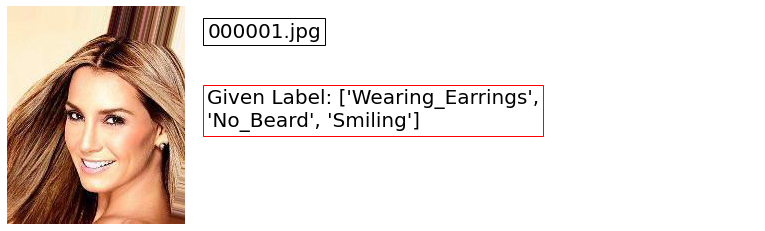

In [9]:
example_to_view = 0  # you can play with this
plot_image(example_to_view)

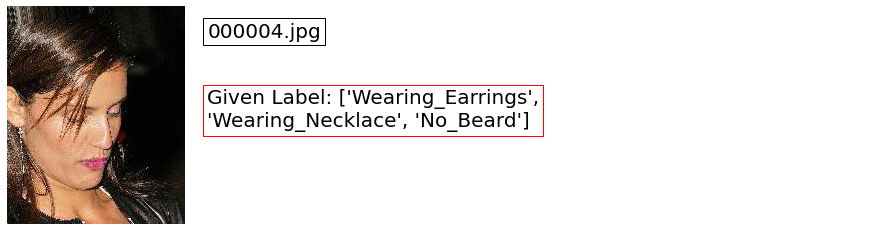

In [10]:
example_to_view = 3
plot_image(example_to_view)

## 3. Use cleanlab to find label issues 

Based on the given `labels` and `pred_probs` from a trained model, cleanlab can quickly help us find label errors in our dataset. Here we request that the indices of the examples identified with label issues be sorted by cleanlab’s normalized margin score, which is used to measure the quality of individual labels. The returned `issues` are a list of indices corresponding to the examples in your dataset that cleanlab finds most likely to be mislabeled. 


In [11]:
issues = find_label_issues(
    labels=labels,
    pred_probs=pred_probs,
    multi_label=True,
    return_indices_ranked_by="normalized_margin",
)

Note we specified the `multi_label` option above to distinguish the task from *multi-class classification* (otherwise assumed as the default task).

Let's look at some of the CelebA images that cleanlab thinks are most likely to be mislabeled, and also print the classes a trained model predicts for each of these images. You can see that among many of these examples, the given label does not seem like the best set of tags to apply for the corresponding image.

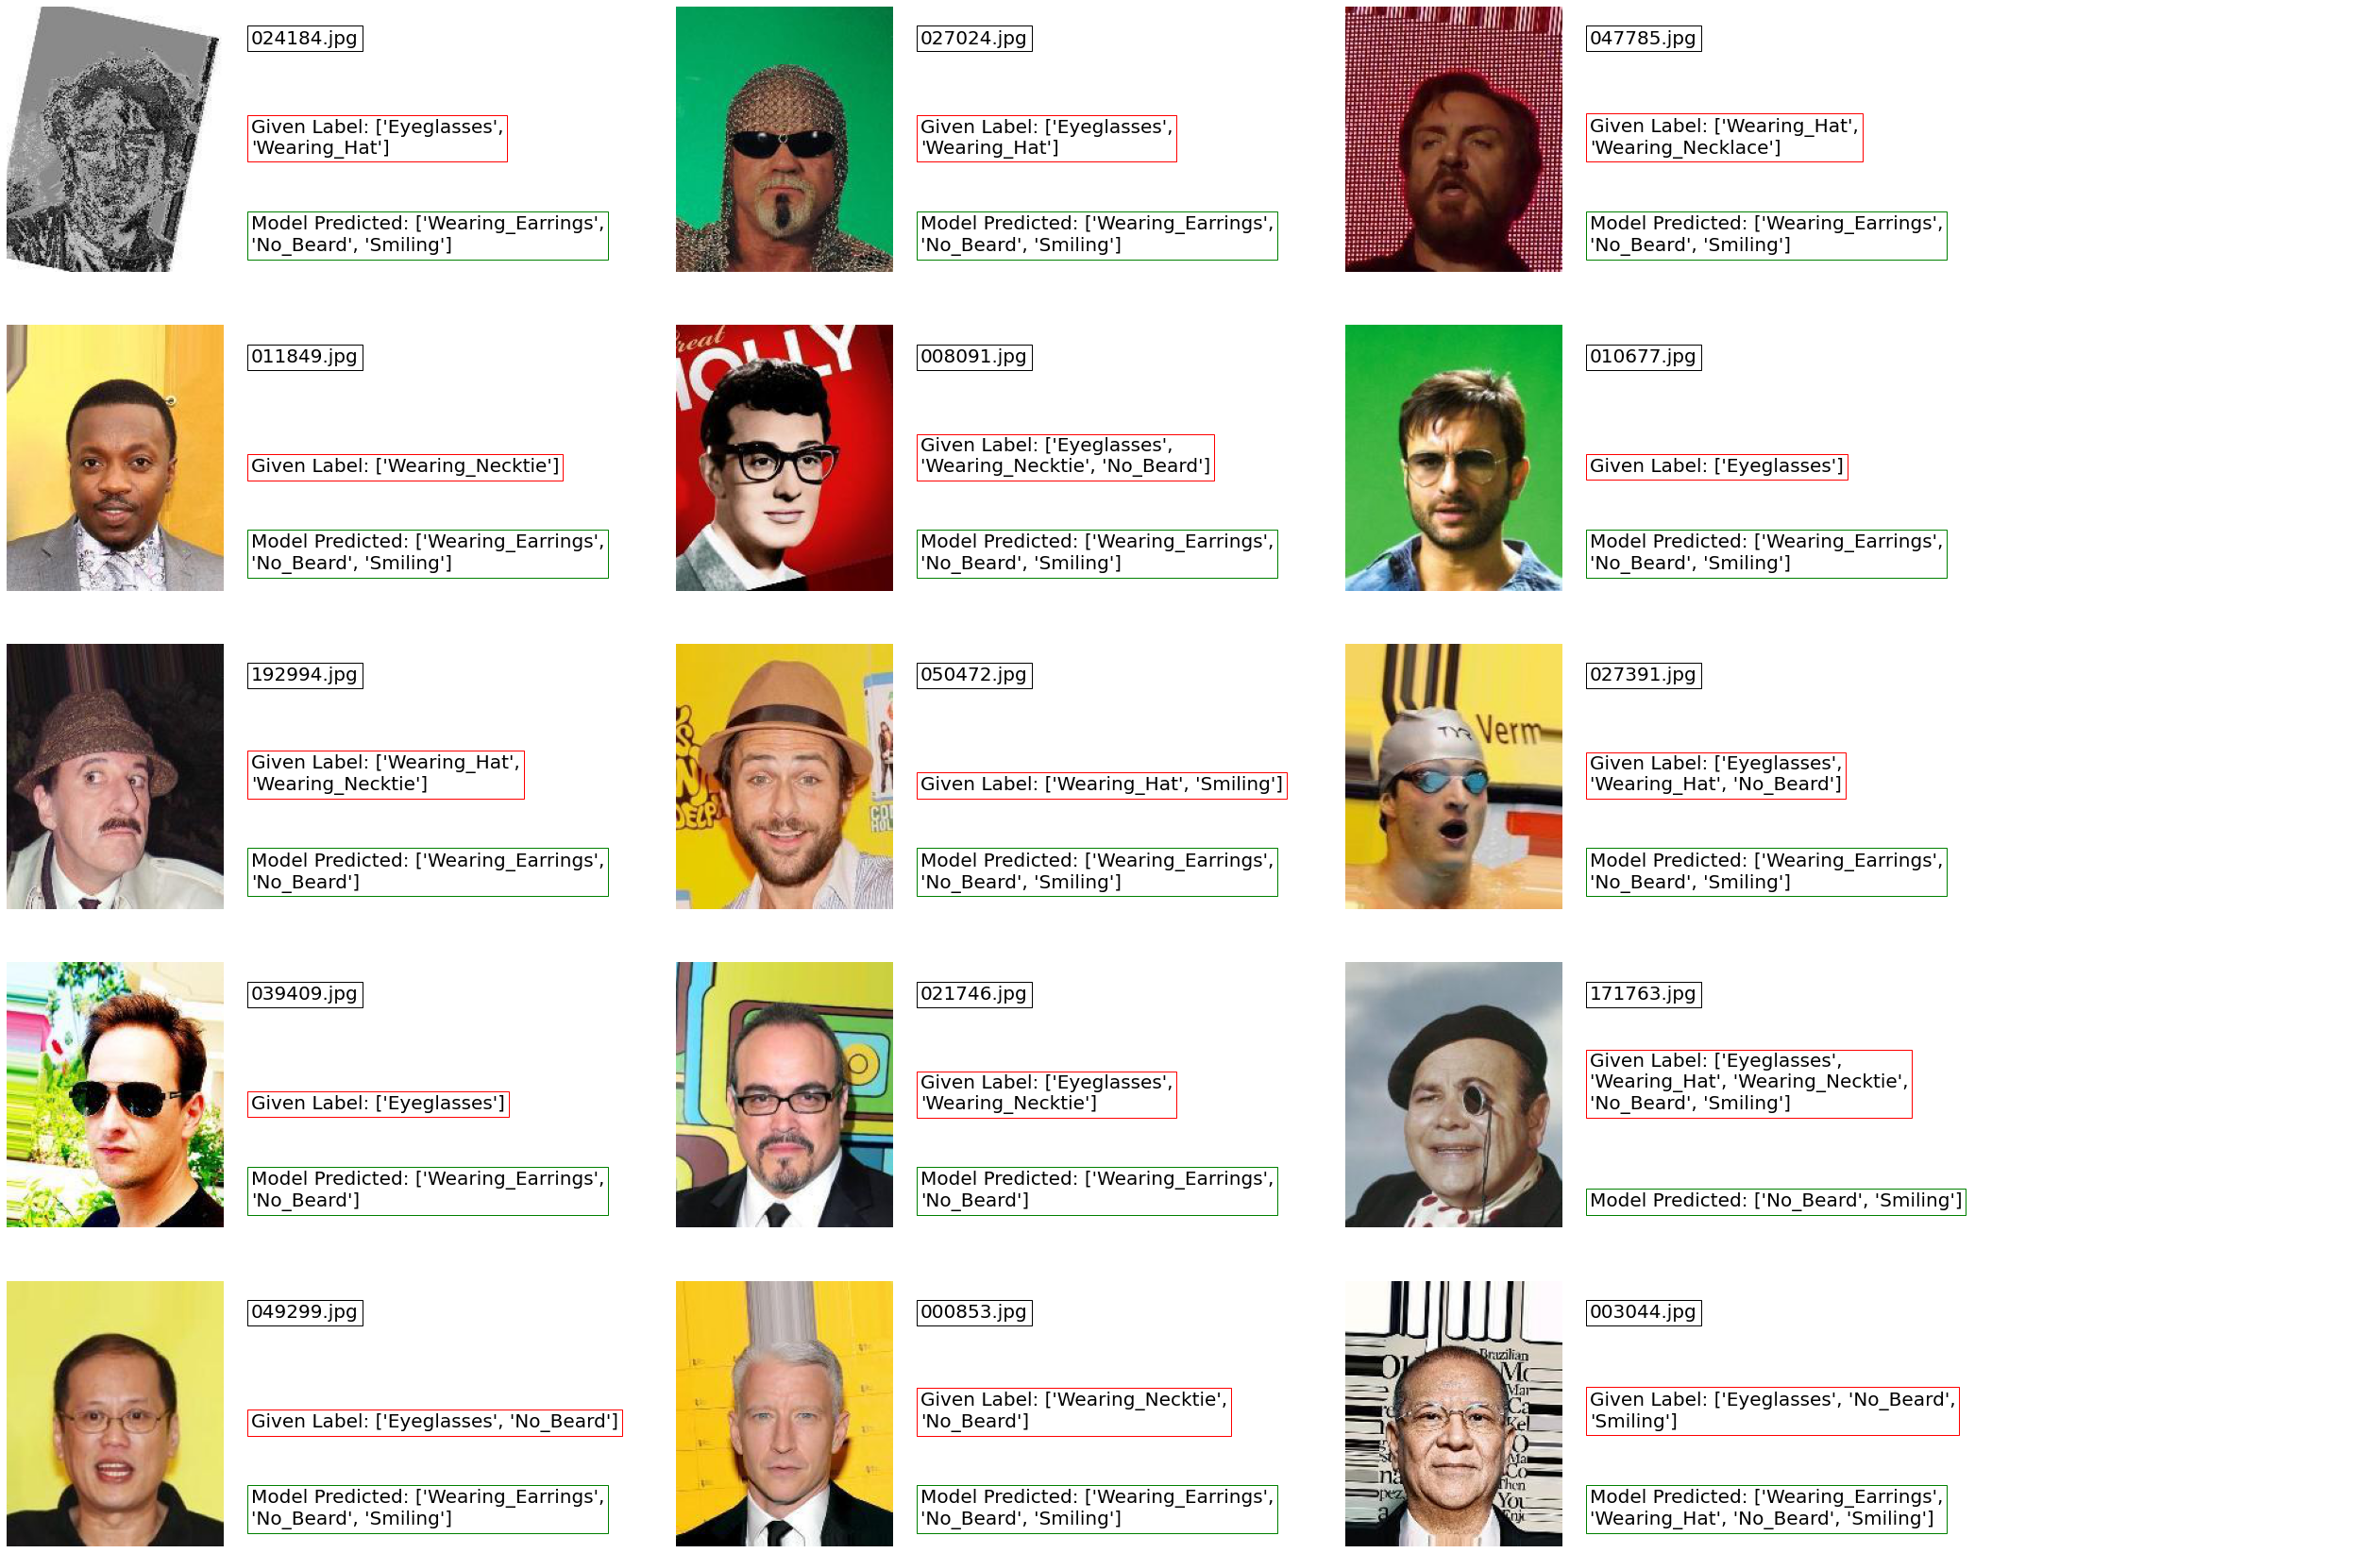

In [12]:
rows = 5  # increase this to see additional examples that are likely mislabeled

fig = plt.figure(figsize=(36, 30))
columns = 3
ct = 0
for i in range(1, columns * rows + 1):
    pos = issues[ct]
    label_error = label_names[pos]
    fig.add_subplot(
        rows,
        columns,
        i,
    )
    plot_image(pos, pred_label_names[pos])
    ct += 1

### How to format labels given as a one-hot (multi-hot) binary matrix?

For multi-label classification, cleanlab expects labels to be formatted as a list of lists, where each entry is an integer corresponding to a particular class. Here are some functions you can use to easily convert labels between this format and a binary matrix format commonly used to train multi-label classification models.

In [13]:
from cleanlab.internal.multilabel_utils import int2onehot, onehot2int

labels_binary_format = int2onehot(labels, K=len(class_names))
labels_list_format = onehot2int(labels_binary_format)

Recall this tutorial just loaded already-computed `pred_probs` produced in our [example](https://github.com/cleanlab/examples) notebook ["Train a neural network for multi-label classification on the CelebA dataset"](https://github.com/cleanlab/examples/blob/master/multilabel_classification/pytorch_network_training.ipynb). 
Check out that notebook to learn how to use a state-of-the-art Pytorch neural network for multi-label classification with image data.

In [14]:
# Note: This cell is only for docs.cleanlab.ai, if running on local Jupyter or Colab, please ignore it.

# highlighted_indices = [
#     22476,
#     44399,
#     10996,
#     7507,
# ]
# if not all(x in issues for x in highlighted_indices):
#     raise Exception("Some highlighted examples are missing from ranked_label_issues.")